In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Neural Process for age estimation(multi-task)

This notebook shows how to train and sample from a Neural Process for a class of age estimation in multi-task learning way
There are (num_of_persons) tasks.
In each task, there are (num_of_images) context points

### Read Dataset

In [2]:
from datasets import FaceFeatureData

# Create dataset

num_of_people = 3
num_of_images=18
dataset = FaceFeatureData(num_of_people=num_of_people,num_of_images=num_of_images)

#82 different people(batch_num)
#18 different images each people(batch_size)
#x_dim = 2048

### Build Neural Process

In [3]:

from neural_process import NeuralProcess

x_dim = 2048
y_dim = 1
r_dim = 50  # Dimension of representation of context points
z_dim = 50  # Dimension of sampled latent variable
h_dim = 50  # Dimension of hidden layers in encoder and decoder

neuralprocess = NeuralProcess(x_dim, y_dim, r_dim, z_dim, h_dim)

### Train Neural Process 1st time
the first time(all the parameter will be updated)

Epoch: 0, Avg_loss: 16910.486002604168
Epoch: 1, Avg_loss: 15968.4580078125
Epoch: 2, Avg_loss: 14776.721354166666
Epoch: 3, Avg_loss: 13847.9873046875
Epoch: 4, Avg_loss: 12472.329752604166
Epoch: 5, Avg_loss: 10979.1259765625
Epoch: 6, Avg_loss: 9994.372233072916
Epoch: 7, Avg_loss: 8267.152018229166
Epoch: 8, Avg_loss: 7428.741943359375
Epoch: 9, Avg_loss: 5838.3388671875
Epoch: 10, Avg_loss: 5060.749837239583
Epoch: 11, Avg_loss: 4269.94482421875
Epoch: 12, Avg_loss: 3346.3447265625
Epoch: 13, Avg_loss: 2899.9271647135415
Epoch: 14, Avg_loss: 2400.0933430989585
Epoch: 15, Avg_loss: 2027.9395548502605
Epoch: 16, Avg_loss: 1699.0258382161458
Epoch: 17, Avg_loss: 1444.4285481770833
Epoch: 18, Avg_loss: 1278.001708984375
Epoch: 19, Avg_loss: 1116.4388122558594
Epoch: 20, Avg_loss: 925.4253845214844
Epoch: 21, Avg_loss: 856.5559387207031
Epoch: 22, Avg_loss: 725.3132731119791
Epoch: 23, Avg_loss: 619.1784057617188
Epoch: 24, Avg_loss: 552.050526936849
Epoch: 25, Avg_loss: 497.0937856038

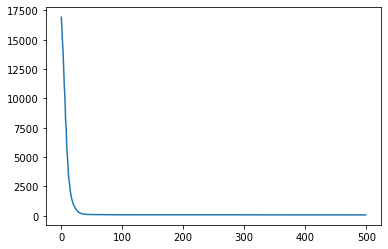

In [4]:
from torch.utils.data import DataLoader
from training import NeuralProcessTrainer

batch_size = 1
num_context = 17
num_target = 1

data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
optimizer = torch.optim.Adam(neuralprocess.parameters(), lr=3e-4)
np_trainer = NeuralProcessTrainer(device, neuralprocess, optimizer,
                                  num_context_range=(num_context, num_context),
                                  num_extra_target_range=(num_target, num_target), 
                                  print_freq=200)

neuralprocess.training = True
np_trainer.train(data_loader, 500)
#save first model parameters trained on the whole dataset
torch.save(neuralprocess.state_dict(), r'D:\PycharmProjects\ANP\neural-processes-oxford\trained_models\age_estimation\firstWholeTrained.ckpt')
plt.plot(range(len(np_trainer.epoch_loss_history)),np_trainer.epoch_loss_history)
plt.show()


### Train Neural Process 2nd time
(the parameter of encoder will be frozen)

the structure of neural process network(3-layer network):
layer 1: xy_to_r

layer 2: r_to_mu_sigma

layer 3: xz_to_y


Epoch: 0, Avg_loss: 67.59355926513672
Epoch: 1, Avg_loss: 67.4148941040039
Epoch: 2, Avg_loss: 64.82443237304688
Epoch: 3, Avg_loss: 65.03349304199219
Epoch: 4, Avg_loss: 66.09268951416016
Epoch: 5, Avg_loss: 63.724693298339844
Epoch: 6, Avg_loss: 64.07089233398438
Epoch: 7, Avg_loss: 63.806514739990234
Epoch: 8, Avg_loss: 64.3572998046875
Epoch: 9, Avg_loss: 63.60342025756836
Epoch: 10, Avg_loss: 64.11699676513672
Epoch: 11, Avg_loss: 65.07807159423828
Epoch: 12, Avg_loss: 63.531978607177734
Epoch: 13, Avg_loss: 63.17070770263672
Epoch: 14, Avg_loss: 63.080528259277344
Epoch: 15, Avg_loss: 64.17915344238281
Epoch: 16, Avg_loss: 63.6990966796875
Epoch: 17, Avg_loss: 62.94781494140625
Epoch: 18, Avg_loss: 62.929080963134766
Epoch: 19, Avg_loss: 62.88380432128906
Epoch: 20, Avg_loss: 62.74314880371094
Epoch: 21, Avg_loss: 63.634742736816406
Epoch: 22, Avg_loss: 62.664302825927734
Epoch: 23, Avg_loss: 62.71478271484375
Epoch: 24, Avg_loss: 62.66484069824219
Epoch: 25, Avg_loss: 62.7920303

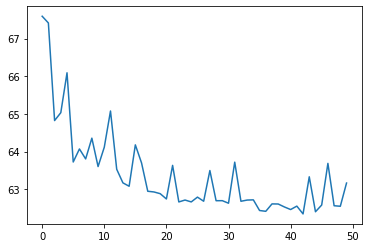

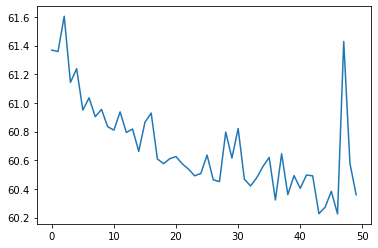

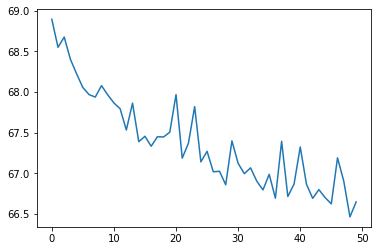

In [5]:
singlePersonDatasets = []
for idx in range(num_of_people):
    singlePersonDataset = FaceFeatureData(num_of_people=num_of_people,num_of_images=num_of_images,index=idx)
    singlePersonDatasets.append(singlePersonDataset)

for idx, singlePersonDataset in enumerate(singlePersonDatasets):
    #load model
    smallNeuralprocess = NeuralProcess(x_dim, y_dim, r_dim, z_dim, h_dim)
    smallNeuralprocess.load_state_dict(torch.load(r'D:\PycharmProjects\ANP\neural-processes-oxford\trained_models\age_estimation\firstWholeTrained.ckpt'))
    
    singleData_loader = DataLoader(singlePersonDataset, batch_size=batch_size, shuffle=True)
    smallOptimizer = torch.optim.SGD(smallNeuralprocess.parameters(), lr=3e-5)
    smallNp_trainer = NeuralProcessTrainer(device, smallNeuralprocess, smallOptimizer,
                                  num_context_range=(num_context, num_context),
                                  num_extra_target_range=(num_target, num_target), 
                                  print_freq=200)
    smallNeuralprocess.training = True
    smallNp_trainer.train(singleData_loader, 50)
    #save first model parameters trained on the whole dataset
    path = r'D:\PycharmProjects\ANP\neural-processes-oxford\trained_models\age_estimation\smallTrained\smallTrained' + str(idx) + r'.ckpt'
    torch.save(smallNeuralprocess.state_dict(),path)
    plt.plot(range(len(smallNp_trainer.epoch_loss_history)),smallNp_trainer.epoch_loss_history)
    plt.show()



### Construct input to MergeNet
Let new dataset(new person who is not in trainset)

In [6]:
from utils import context_target_split
from datasets import FaceFeatureTestData
import os


for batch in data_loader:
    break
# Use batch to create random set of context points
x, y = batch
x_context, y_context, _, _ = context_target_split(x[0:1], y[0:1], 
                                                  num_context, 
                                                  num_target)

modelPath = r'D:\PycharmProjects\ANP\neural-processes-oxford\trained_models\age_estimation\smallTrained'
models = os.listdir(modelPath)
smallModels = map(lambda x: os.path.join(modelPath, x), models)

num_of_test_images = 18
test_target = 0
resultsOnPretrainedModelsList = [] 
for idx, root_dir in enumerate(smallModels):
    #load model
    testNeuralprocess = NeuralProcess(x_dim, y_dim, r_dim, z_dim, h_dim)
    testModelPath = r'D:\PycharmProjects\ANP\neural-processes-oxford\trained_models\age_estimation\smallTrained\smallTrained' + str(idx) + r'.ckpt'
    testNeuralprocess.load_state_dict(torch.load(testModelPath))
    testNeuralprocess.training = False

    testDataset = FaceFeatureTestData()
    testData_loader = DataLoader(testDataset, batch_size=batch_size, shuffle=True)
    resultsOnPretrainedModel = []
    for x_target, y_target in testData_loader:
        test_target = y_target
        avg_mu = 0
        for i in range(10):
            p_y_pred = testNeuralprocess(x_context, y_context, x_target)
            # Extract mean of distribution
            mu = p_y_pred.loc.detach()
            avg_mu += mu
        avg_mu = avg_mu / 10
        print('avg_mu.size(): ',avg_mu.size())
        print(avg_mu)
        avg_mu = avg_mu.view(18)
        print('after view operation')
        print('avg_mu.size(): ',avg_mu.size())
        print(avg_mu)
        resultsOnPretrainedModel.append(avg_mu.tolist())
    resultsOnPretrainedModelsList.append(resultsOnPretrainedModel)
print(resultsOnPretrainedModelsList)

resultsOnPretrainedModels = []
for i in range(num_of_test_images):
    resultsWithSinglePerson = []
    for list in resultsOnPretrainedModelsList:
        resultsWithSinglePerson.append(list[0][i])
    resultsOnPretrainedModels.append(resultsWithSinglePerson)
resultsOnPretrainedModels = torch.FloatTensor(resultsOnPretrainedModels)

avg_mu.size():  torch.Size([1, 18, 1])
tensor([[[39.2867],
         [33.4861],
         [26.0373],
         [20.3277],
         [31.6407],
         [27.1743],
         [23.6784],
         [30.0131],
         [31.0625],
         [21.5425],
         [22.1904],
         [29.3930],
         [25.1870],
         [33.7919],
         [34.4956],
         [33.2880],
         [20.3352],
         [28.2795]]])
after view operation
avg_mu.size():  torch.Size([18])
tensor([39.2867, 33.4861, 26.0373, 20.3277, 31.6407, 27.1743, 23.6784, 30.0131,
        31.0625, 21.5425, 22.1904, 29.3930, 25.1870, 33.7919, 34.4956, 33.2880,
        20.3352, 28.2795])
avg_mu.size():  torch.Size([1, 18, 1])
tensor([[[49.4424],
         [43.0957],
         [35.3228],
         [29.2181],
         [41.1089],
         [36.5273],
         [32.8362],
         [39.3366],
         [40.7799],
         [30.4799],
         [31.2547],
         [39.0178],
         [34.4124],
         [43.5453],
         [44.2046],
         [42.9115],

### Training MergeNet

Epoch: 0, loss: 5324.2802734375
Epoch: 1, loss: 5277.74462890625
Epoch: 2, loss: 5231.421875
Epoch: 3, loss: 5185.31640625
Epoch: 4, loss: 5139.4296875
Epoch: 5, loss: 5093.76953125
Epoch: 6, loss: 5048.3349609375
Epoch: 7, loss: 5003.13134765625
Epoch: 8, loss: 4958.162109375
Epoch: 9, loss: 4913.4296875
Epoch: 10, loss: 4868.93603515625
Epoch: 11, loss: 4824.685546875
Epoch: 12, loss: 4780.681640625
Epoch: 13, loss: 4736.92626953125
Epoch: 14, loss: 4693.42041015625
Epoch: 15, loss: 4650.1689453125
Epoch: 16, loss: 4607.17236328125
Epoch: 17, loss: 4564.43212890625
Epoch: 18, loss: 4521.95263671875
Epoch: 19, loss: 4479.73388671875
Epoch: 20, loss: 4437.779296875
Epoch: 21, loss: 4396.08837890625
Epoch: 22, loss: 4354.6650390625
Epoch: 23, loss: 4313.5087890625
Epoch: 24, loss: 4272.62109375
Epoch: 25, loss: 4232.00341796875
Epoch: 26, loss: 4191.6572265625
Epoch: 27, loss: 4151.58203125
Epoch: 28, loss: 4111.77978515625
Epoch: 29, loss: 4072.25
Epoch: 30, loss: 4032.994384765625
Epo

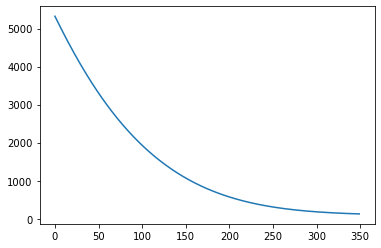

In [7]:
from mergeNet import MergeNet

# print(resultsOnPretrainedModels)
# print(resultsOnPretrainedModels.size())

mergeNet = MergeNet(number_of_trained_people=3)
mergeOptimizer = torch.optim.Adam(mergeNet.parameters(), lr=3e-3)
mergeEpoch = 350
criterion = torch.nn.MSELoss()
test_target = test_target.view(num_of_test_images,1)
merge_loss_history = []
for epoch in range(mergeEpoch):
    mergeOptimizer.zero_grad()
    mergeResult = mergeNet(resultsOnPretrainedModels)
    loss = criterion(mergeResult, test_target)
    loss.backward()
    mergeOptimizer.step()
    print("Epoch: {}, loss: {}".format(epoch, loss))
    merge_loss_history.append(loss)
plt.plot(range(len(merge_loss_history)),merge_loss_history)
plt.show()
#save mergeNet
path = r'D:\PycharmProjects\ANP\neural-processes-oxford\trained_models\mergeNet.ckpt'
torch.save(mergeNet.state_dict(),path)

In [10]:
from multiTaskAgeEstimation import ConstructInputToMergeNet

finalTestDataset = FaceFeatureTestData(r'D:\PycharmProjects\ANP\neural-processes-oxford\FinalTestFeatureVector')
finalTestData_loader = DataLoader(finalTestDataset, batch_size=batch_size, shuffle=True)
finalResultsOnPretrainedModels = ConstructInputToMergeNet(num_of_test_images,finalTestData_loader)
testMergeNet = MergeNet(number_of_trained_people=3)
testMergeNet.load_state_dict(torch.load(r'D:\PycharmProjects\ANP\neural-processes-oxford\trained_models\mergeNet.ckpt'))

final_predict_value = testMergeNet(finalResultsOnPretrainedModels)
print('final result: ')
print(final_predict_value)
for _,target_y in finalTestData_loader:
    print(target_y)


avg_mu.size():  torch.Size([1, 18, 1])
tensor([[[19.8446],
         [20.1559],
         [20.1543],
         [16.9586],
         [28.8354],
         [34.8980],
         [28.9554],
         [25.3711],
         [34.8039],
         [32.7236],
         [30.3030],
         [33.8969],
         [27.0947],
         [28.1515],
         [29.9826],
         [33.1234],
         [20.6489],
         [24.5315]]])
after view operation
avg_mu.size():  torch.Size([18])
tensor([19.8446, 20.1559, 20.1543, 16.9586, 28.8354, 34.8980, 28.9554, 25.3711,
        34.8039, 32.7236, 30.3030, 33.8969, 27.0947, 28.1515, 29.9826, 33.1234,
        20.6489, 24.5315])
avg_mu.size():  torch.Size([1, 18, 1])
tensor([[[28.8692],
         [29.1844],
         [29.1788],
         [25.6628],
         [38.5491],
         [44.9598],
         [38.5094],
         [34.7171],
         [44.8321],
         [42.5432],
         [40.0848],
         [43.9297],
         [36.6968],
         [37.6368],
         [39.6453],
         [42.9451],